In [1]:
import os
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension
import numpy as np
import xarray as xr

In [2]:
def plotsdir(x = ""): 
    return "/scratch/anthony.meza/CM4X/CM4XTransientTracers/figures" + x

In [3]:
import gsw, xwmt, xgcm
import cmocean.cm as cm

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='40GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=38G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.73:40583 --nthreads 36 --memory-limit 37.25GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.73:40583,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
def get_sigma2(ds, keep_vars = False): 
    ds['p'] = xr.apply_ufunc(
        gsw.p_from_z, ds.z, ds.lat, 0, 0, dask="parallelized"
    )


    ds['sa'] = xr.apply_ufunc(
        gsw.SA_from_SP,
        ds.so,
        ds.p,
        ds.lon,
        ds.lat,
        dask="parallelized",
    )
    ds['ct'] = xr.apply_ufunc(
        gsw.CT_from_t,
        ds.sa,
        ds.thetao,
        ds.p,
        dask="parallelized"
    )

    ds['sigma2'] = xr.apply_ufunc(
        gsw.sigma2,
        ds.sa,
        ds.ct,
        dask="parallelized"
    )
    if keep_vars: 
        return ds
    else: 
        return ds.drop_vars(["p", "sa", "ct"])

In [7]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1, "depth":2},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [8]:
CM4Xp25_historical = read_CM4X("../../CM4Xp25_historical_transient_tracers.zarr")
CM4Xp25_ssp585 = read_CM4X("../../CM4Xp25_ssp585_transient_tracers.zarr")
CM4Xp25_piControl = read_CM4X("../../CM4Xp25_piControl_transient_tracers.zarr")

In [9]:
cimoli_fnames = ["../../CimoliData/CFC.nc", "../../CimoliData/CFC11.nc", "../../CimoliData/SF6.nc"]

In [11]:
cimoli_ds = xr.open_mfdataset(cimoli_fnames, data_vars="minimal",
        coords="minimal",
        compat="override",parallel=True,
        chunks={"latitude":-1, "longitude":-1, "time":-1})

In [17]:
cimoli_ds.longitude

<xarray.DataArray 'longitude' (longitude: 720)>
array([  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5])
Coordinates:
  * longitude  (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5

In [ ]:
cimoli_ds

In [9]:
CFC_12_C = 
CFC_11_C = xr.open_mfdataset()
SF6_C = xr.open_mfdataset()

In [53]:
diff = -300 
def get_time_series_cimoli(ds):
    return ds.sel(longitude = slice(200, 220), latitude = slice(-40, -20)).mean(["longitude", "latitude"])
    
def get_time_series_CM4X(ds):
    ds = ds.sel(xh = slice(200 + diff, 220 + diff), yh = slice(-40, -20))
    ds = (ds * ds.thkcello).sum(["xh", "yh"]) / ds.thkcello.sum(["xh", "yh"])
    ds = ds.compute()
    ds["lon"] = 210
    ds["lat"] = -30

    return ds


In [54]:
CM4_timeseries = get_time_series_CM4X(CM4Xp25_historical)
CM4_timeseries = get_sigma2(CM4_timeseries).compute()
CFC_12_ts = get_time_series_cimoli(CFC_12_C).compute()
CFC_11_ts = get_time_series_cimoli(CFC_11_C).compute()
SF6_ts = get_time_series_cimoli(SF6_C).compute()

In [55]:
from scipy.interpolate import interp1d

In [68]:
CM4_sigma2 = CM4_timeseries.sigma2.values 
mask = (CM4_sigma2 > 35.5) * (CM4_sigma2 < 35.71)
CFC_masked = (CM4_timeseries.cfc12 * mask * CM4_timeseries.thkcello).mean("zl")* 1e9

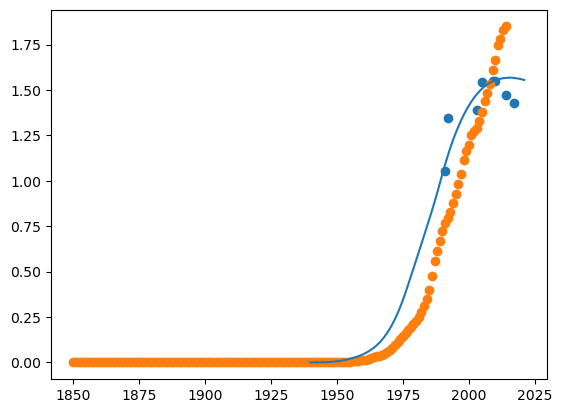

In [69]:
x = CFC_12_ts.sel(gamma_n = 2600, method = "nearest").cfc12_obs
x_rec = CFC_12_ts.sel(gamma_n = 2600, method = "nearest").cfc12_rec

plt.plot(CFC_12_ts.time, x_rec)
plt.scatter(CFC_12_ts.time, x)
plt.scatter(CFC_masked.year, CFC_masked)

In [70]:
CM4_sigma2 = CM4_timeseries.sigma2.values 
mask = (CM4_sigma2 > 35.5) * (CM4_sigma2 < 35.71)

CFC_masked = 1e9 * (CM4_timeseries.cfc11 * mask * CM4_timeseries.thkcello).sum("zl") / (mask * CM4_timeseries.thkcello).sum("zl")




In [81]:
CM4_sigma2 = CM4_timeseries.sigma2.values 
mask = (CM4_sigma2 > 35.2) * (CM4_sigma2 < 35.8)
CFC_masked = 1e9 * (CM4_timeseries.sf6 * mask * CM4_timeseries.thkcello).sum("zl") / (mask * CM4_timeseries.thkcello).sum("zl")

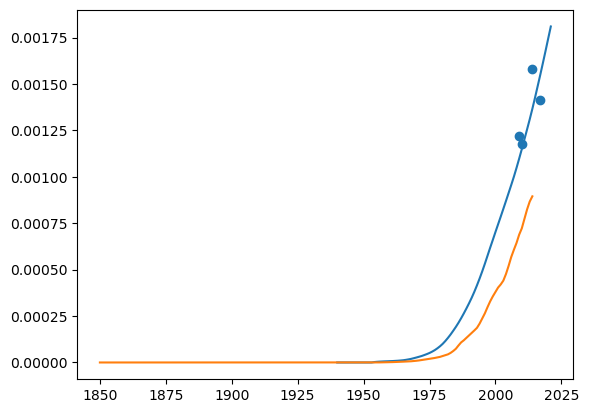

In [82]:
x = SF6_ts.sel(gamma_n = 2600, method = "nearest").sf6_obs
x_rec = SF6_ts.sel(gamma_n = 2600, method = "nearest").sf6_rec

plt.plot(CFC_12_ts.time, x_rec)
plt.scatter(CFC_12_ts.time, x)
plt.plot(CFC_masked.year, CFC_masked)

In [90]:
new_sigma_grid = np.linspace(CM4_timeseries.sigma2[0, :].min(), CM4_timeseries.sigma2[0, :].max())
def interpolate_values(ds_sigma, ds_val):
    unique_sigma, inds = np.unique(ds.sigma2, return_index = True)
    interp = interp1d(unique_sigma, ds_val.values[inds], 
                      bounds_error = False, kind = "cubic", fill_value=np.nan)
    return interp(new_sigma_grid)
    


CFC12_interp = np.zeros((len(new_sigma_grid), CM4_timeseries.cfc12.shape[0]))

for (i, y) in enumerate(CM4_timeseries.year):
    ds = CM4_timeseries.isel(year = i)
    CFC12_interp[:, i] = interpolate_values(ds.sigma2, ds.cfc12)[:]

Text(510.3244949494949, 0.5, '$\\gamma_n$')

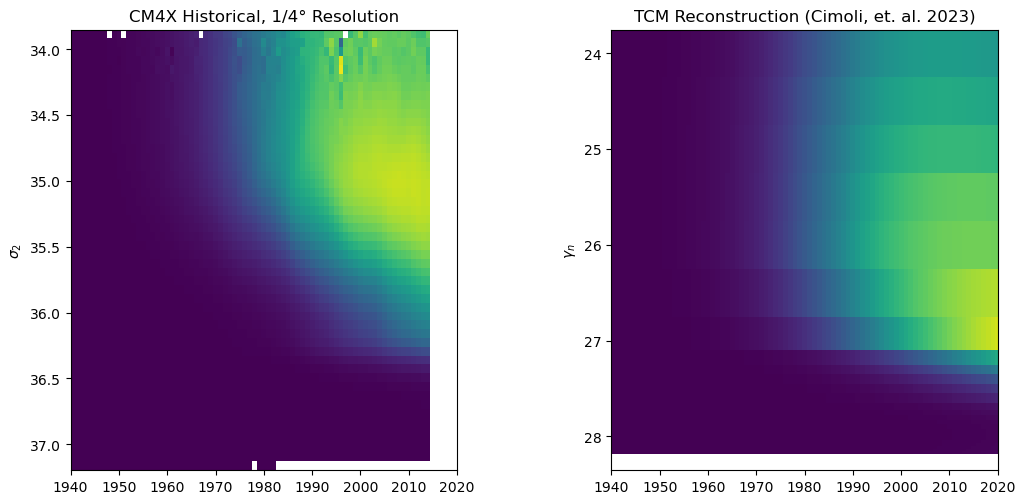

In [93]:
fig, ax = plt.subplots(1,2,figsize=(10, 5), sharey = False, sharex = True)
# fig.suptitle("Average CFC-12, CFC-11 and SF6 Concentrations along section P16 \n t = 2010 - 2014", fontsize = 14, y = 1, x = 0.5)

fig.tight_layout()
fig.subplots_adjust(wspace = 0.4, hspace = 0.3)


# [a.set_ylim(23, 28) for a in axes[:, 1].flatten()]
# [a.set_ylim(30, 37) for a in axes[:, 0].flatten()]
[a.set_xlim(1940, 2020) for a in ax.flatten()]


ax[0].pcolormesh(CM4_timeseries.year,new_sigma_grid,CFC12_interp * 1e9, vmin = 0, vmax = 2, shading = "nearest")
ax[1].pcolormesh(CFC_12_ts.time,CFC_12_ts.gamma_n / 100,CFC_12_ts.cfc12_rec, vmin = 0, vmax = 2,shading = "nearest")

# fig.colorbar(cm, ax = ax[:], label = "CFC12 [pmol/kg]", orientation = "vertical", fraction = 0.06)
[a.invert_yaxis() for a in ax[:]]
ax[0].set_title("CM4X Historical, 1/4° Resolution")
ax[1].set_title("TCM Reconstruction (Cimoli, et. al. 2023)")
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\gamma_n$")